In [1]:
from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=14)

# Random Query Data

In [2]:
query_tag = 'saved/2020-05-25T18:07:55.704835'
query_conf_name ='query_cycles'
algorithms = ['charge']

In [3]:
def get_query_data(tag, conf_name, algorithms):
    # Paths to Benchmark Results
    result_dir = Path('./results').joinpath(tag, conf_name)
    
    data = {}
    for alg in algorithms:
        path = result_dir.joinpath(f'{alg}.csv')
        data[alg] = pd.read_csv(path,dtype={'start_node': str, 'target_node': str})

    return data
query_data = get_query_data(query_tag, query_conf_name, algorithms)['charge']

In [4]:
query_data.head()

start_node target_node  query_time    trip_time  nodes   edges  \
0  1818192324   563891042    4.347978  1516.057241  53509  117187   
1   866359483   954303979    0.097798   111.054868  53509  117187   
2   672963211  6535929547   22.595656  1706.709976  53509  117187   
3   322879733  3143348032  209.955545  6027.668864  53509  117187   
4  6254090150   267734888    6.295368   664.992671  53509  117187   

   charging_stations  charging_stops  charging_time  dominance_checks  \
0                 40               0              0            134752   
1                 40               0              0                90   
2                 40               0              0            612399   
3                 40               0              0           5732090   
4                 40               0              0            171115   

  tweak_on  tweak_depth  
0       on            0  
1       on            0  
2       on            0  
3       on            0  
4       on            0

In [5]:
def plot_query_cycle_alt(query_data):    
    def rel_diff(x):
        return (x[0] - x[1]) / x[0]
    

    query_data = query_data.sort_values(by=['start_node', 'target_node', 'tweak_depth'])
    query_data['diff_checks'] = query_data['dominance_checks'].rolling(window=2).apply(rel_diff, raw=True)
    query_data['diff_time'] = query_data['query_time'].rolling(window=2).apply(rel_diff, raw=True)
    
    fig, ax = plt.subplots(figsize=(4.5,4))
    y = query_data.groupby('tweak_depth').mean()
    std = query_data.groupby('tweak_depth').std()
    ax.errorbar(x=y.index[1:] + 1, 
                y=y['diff_checks'].iloc[1:],
                yerr=std['diff_checks'].iloc[1:],
                marker='o', 
                capsize=4
               )
    print(y['diff_checks'].iloc[1:])
    print(std['diff_checks'].iloc[1:])
    ax.set_xticks(y.index[1:] + 1)
    ax.set_yscale('log')
    ax.set_xlabel('Maximallänge der ausgschlossenen Kreise')
    ax.set_ylabel('$\Delta$ Labelvergleiche')
    fig.tight_layout()
    fig.savefig('img/kreise.pdf', bbox='tight')
    
    fig, ax = plt.subplots(figsize=(4.5,4))
    ax.errorbar(x=y.index[1:] + 1, 
                y=y['diff_time'].iloc[1:] * 100,
                yerr=std['diff_time'].iloc[1:] * 100,
                marker='o', 
                capsize=4
               )
    ax.set_xticks(y.index[1:] + 1)
    #ax.set_yscale('log')
    ax.set_xlabel('Maximallänge der ausgschlossenen Kreise')
    ax.set_ylabel('$\Delta$ Laufzeit in \%')
    fig.tight_layout()
    fig.savefig('img/kreise_zeit.pdf', bbox='tight')


tweak_depth
1    0.514315
2    0.002519
3    0.001752
4    0.001282
5    0.000426
Name: diff_checks, dtype: float64
tweak_depth
1    0.146701
2    0.001500
3    0.001046
4    0.000972
5    0.000287
Name: diff_checks, dtype: float64


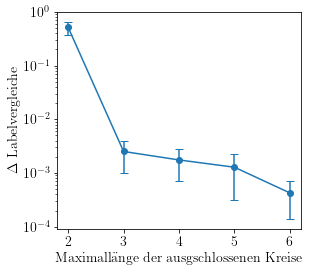

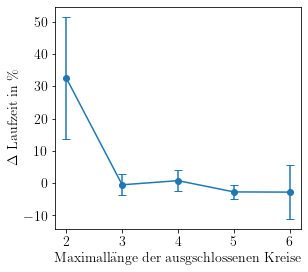

In [6]:
plot_query_cycle_alt(query_data)